(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

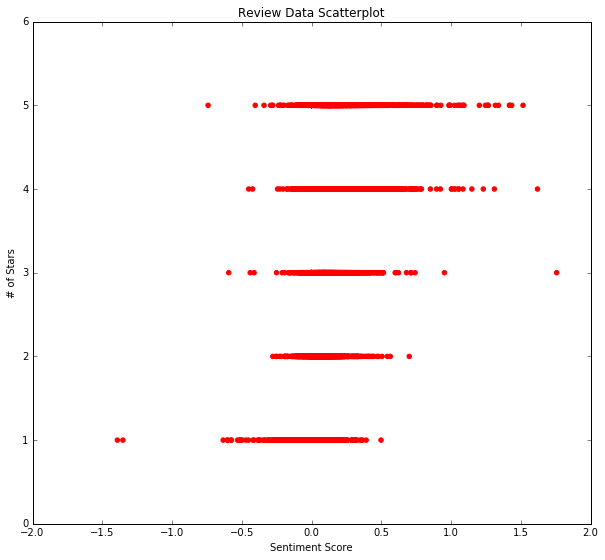

('Time: ', 1.1952409744262695)
      stars     sentiment
3739      1  1.209731e-01
6384      1 -1.579782e-01
2119      1 -5.311960e-01
2116      1 -1.748330e-01
2113      1  4.247651e-02
2112      1  3.121438e-02
2109      1  5.622500e-02
7754      1 -2.315278e-01
9331      1 -5.760448e-01
9333      1  1.114397e-01
9346      1  1.670820e-01
9350      1  1.317575e-01
2064      1 -1.554517e-01
2061      1 -7.037559e-02
9359      1  2.399758e-02
9361      1 -5.161621e-01
9362      1 -2.091864e-01
9364      1  1.405271e-01
7749      1 -2.703565e-02
9366      1  3.467635e-01
9370      1 -1.181250e-01
9373      1 -1.853833e-02
9375      1 -1.738301e-01
2029      1 -7.291586e-02
9328      1 -1.448716e-01
6422      1  6.726918e-02
2143      1 -9.359036e-02
2146      1 -8.247840e-02
2232      1 -3.232327e-03
2230      1  5.468575e-02
...     ...           ...
4569      5  1.972000e-01
4566      5  2.113298e-01
4563      5  2.024691e-01
4562      5  2.716332e-01
4560      5  1.445014e-01
4559   

'\nstart = time.time()\ns1 = sentiment_score("After sitting there and being ignored for 25 minutes we just left!")\nend = time.time() - start\nprint("Time: ", end)\nprint(s1)\n\nsid = SentimentIntensityAnalyzer()\nstart = time.time()\ns2 = sid.polarity_scores("After sitting there and being ignored for 25 minutes we just left!")\ns2 = s2[\'pos\']-s2[\'neg\']\nend = time.time() - start\nprint("Time: ", end)\nprint(s2)\n'

In [38]:
"""
read file
read line by line to extract json object
nltk sentiment intensity analyzer - takes in string returns sentiment
"""

import json
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.stem import *
import matplotlib.pyplot as plt
import pandas as pd
import time

%matplotlib inline

path = "/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/yelp_dataset_challenge_academic_dataset/"
filename = path + "review_sample.json"
stemmer = PorterStemmer()

#Read through the Vader lexicon, put them into global dictionary "words"
lexicons = open("/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/vader_lexicon.txt",'r')
words = dict()
for line in lexicons:
    line = line.split('\t')
    words[line[0]] = [float(line[1]),float(line[2])]
lexicons.close()

#Sentiment scoring function
def sentiment_score(string):
    '''reads a string and runs a stemmer to break down words to evaluate sentimental score'''
    string = string.split()
    #string = [stemmer.stem(word) for word in string]
    raw = 0.0
    length = len(string)
    compound = 0.0
    for i in string:
        if i in words:
            raw += words[i][0] 
            compound = max(compound,words[i][1]) 
    return (raw/length)


#Parse function
def parse(fn=filename):
    '''Read line by line and extract (x,y) coordinates, where x = sentiment intensity and y = star rating'''
    
    data= []
    #sid = SentimentIntensityAnalyzer()
    
    with open(fn,'r') as f:
        for line in f:
            json_line = json.loads(line)
            scores = sentiment_score(json_line['text'])
            #scores = sid.polarity_scores(json_line['text'])
            #scores = (scores['pos']-scores['neg'])*scores['compound']
            stars = json_line['stars']
            data.append((stars,scores))
    
    data = pd.DataFrame(data,columns = ['stars','sentiment'])
    data = data.sort_values('stars')
    data.to_csv('data_sample.csv')
    return data

#test case for parse + sentiment scoring
start = time.time()
d = parse()
visualize(d)
end = time.time() - start
print("Time: ", end)
print(d)

#test case for sentiment scoring
"""
start = time.time()
s1 = sentiment_score("After sitting there and being ignored for 25 minutes we just left!")
end = time.time() - start
print("Time: ", end)
print(s1)

sid = SentimentIntensityAnalyzer()
start = time.time()
s2 = sid.polarity_scores("After sitting there and being ignored for 25 minutes we just left!")
s2 = s2['pos']-s2['neg']
end = time.time() - start
print("Time: ", end)
print(s2)
"""

In [33]:
#visualize funcion
def visualize(data):
    '''Visualizes the sentiment vs star rating data through a scatter plot and runs linear regression'''
    
    x = np.array(data['sentiment'])
    y = np.array(data['stars'])
    
    plt.figure(figsize=(10,9))
    plt.scatter(x, y, color = ['r']*len(y))
    plt.title('Review Data Scatterplot')
    plt.ylabel('# of Stars')
    plt.xlabel('Sentiment Score') 
    plt.show()

Visualization and short (detailed) analysis. **(10 pts)**

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()